In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [297]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [298]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
                    index_col=0)
merged.index = merged.index.str.rstrip('-12345')
mean_df = merged.groupby('ID').mean()
# Get rid of cold work
cw_regex = re.compile("[0-9]+$") 
mean_df['cold_work'] = [int(re.search(cw_regex,x).group()) for x in mean_df.index]
mean_df.index = mean_df.index.str.rstrip('02468')
mean_df.index = mean_df.index.str.rstrip('-')

In [299]:
mean_df

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,cold_work
ID,,,,,,,,,,,,,,,
304,162.000000,0.12000,0.0350,0.08600,-1.54700,0.04900,0.002743,0.0,0.013,2.9,0.0,0.005,1.3,0.0,0
304,105.780000,0.49600,0.1770,0.23900,-1.32200,0.06300,0.002093,50.0,0.014,2.0,59.0,0.006,1.1,-12.0,20
304,100.700000,1.35000,0.3770,0.37700,-1.21600,0.05300,0.001941,57.0,0.022,3.0,79.0,0.012,1.9,-20.0,40
304,91.320000,1.37100,0.5310,0.90900,-1.24900,0.05200,0.002567,98.0,0.010,1.1,139.0,0.015,1.7,3.0,60
304,73.775000,3.96600,1.3495,2.47650,-0.97600,0.06425,0.002420,94.0,0.024,2.7,149.0,0.021,2.4,10.0,80
316,111.240000,0.03900,0.0140,0.01700,-1.50600,0.04600,0.002433,0.0,0.021,4.6,0.0,0.010,2.4,0.0,0
316,69.960000,0.03600,0.0100,0.01600,-1.57300,0.04500,0.002785,42.0,0.032,5.0,37.0,0.004,0.7,30.0,20
316,68.220000,0.04400,0.0160,0.01700,-1.64000,0.04400,0.002494,70.0,0.007,1.0,60.0,0.005,0.8,-34.0,40
316,69.000000,0.04925,0.0165,0.03275,-1.67375,0.04500,0.002292,117.0,0.017,1.8,200.0,0.013,1.0,-57.0,60


## Select columns of interest

In [300]:
mean_df = mean_df[mc.regression_cols_real_data].dropna()

In [303]:
mean_df=mean_df.iloc[10:15]
mean_df

,KJIC,TEP_average,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
ID,,,,,
347,198.50,-1.43700,0.0,0.0,0.0
347,124.06,-1.36400,195.0,202.0,-25.0
347,89.88,-1.27925,182.0,241.0,-28.0
347,77.80,-1.10000,206.0,287.0,-33.0
347,74.00,-0.82200,206.0,255.0,-39.0


## Scale data

In [304]:
mean_df.KJIC = np.log(mean_df.KJIC)
scaled_df = mc.scale_general(mean_df, MinMaxScaler())
scaled_df[0]

/opt/anaconda3/envs/epri/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,KJIC,TEP_average,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
ID,,,,,
347,1.000000,0.000000,0.000000,0.000000,1.000000
347,0.523652,0.118699,0.946602,0.703833,0.358974
347,0.197026,0.256504,0.883495,0.839721,0.282051
347,0.050750,0.547967,1.000000,1.000000,0.153846
347,0.000000,1.000000,1.000000,0.888502,0.000000


<AxesSubplot:>

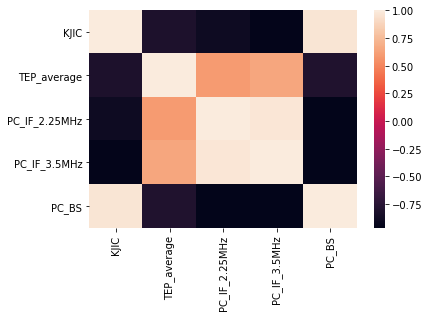

In [305]:
sns.heatmap(mean_df.corr())

In [306]:
# Creating Predictor variable 'X' and Target Variable 'y'

# X contains all the features except for the target value Price
X = scaled_df[0].drop('KJIC', axis = 1)
y = scaled_df[0]['KJIC']

In [307]:
X

,TEP_average,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
ID,,,,
347,0.000000,0.000000,0.000000,1.000000
347,0.118699,0.946602,0.703833,0.358974
347,0.256504,0.883495,0.839721,0.282051
347,0.547967,1.000000,1.000000,0.153846
347,1.000000,1.000000,0.888502,0.000000


In [308]:
from sklearn.model_selection import train_test_split

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)

# X_train contains 70% of total dataset
print(y_train.shape)
# X_test contains 30% of total dataset
print(X_test.shape)

(3,)
(2, 4)


## Linear Regression

In [310]:
from sklearn.linear_model import LinearRegression

In [311]:
lr = LinearRegression()

In [312]:
#Train/fit the model to training data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [313]:
# print the intercept
print(lr.intercept_)

#Coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

0.7454693768696549


,Coefficient
TEP_average,-0.444678
PC_IF_2.25MHz,-0.143289
PC_IF_3.5MHz,-0.177268
PC_BS,0.254531


In [314]:
pred = lr.predict(X_test)

Text(0, 0.5, 'Predicted Fracture Toughness')

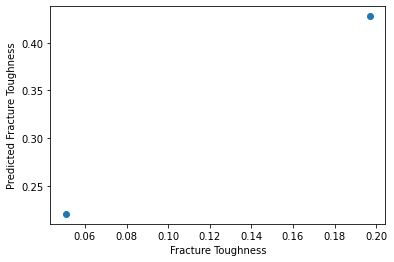

In [315]:
plt.scatter(y_test,pred)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [316]:
from sklearn import metrics

In [317]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.20018715741566456
MSE: 0.04100727185393882
RMSE: 0.20250252308042688


## Ridge Regression

In [318]:
# Ridge Regression
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.0034889737631430733
0.9999270168109304
0.2014612701948666
-6.587472394884213


Text(0, 0.5, 'Predicted Fracture Toughness')

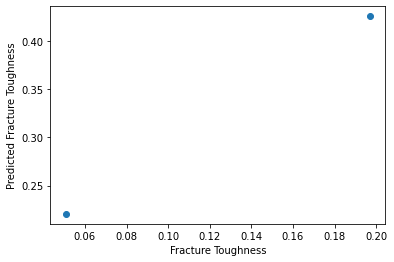

In [319]:
plt.scatter(y_test,pred_test_rr)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Elastic net

In [320]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

0.016376110872661154
0.9983921372672986
0.21939483123763354
-7.99843060702989


Text(0, 0.5, 'Predicted Fracture Toughness')

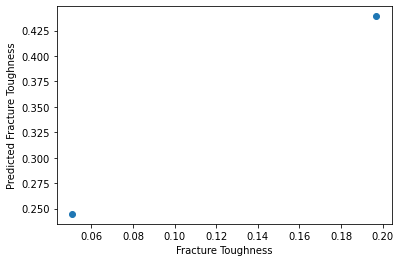

In [321]:
plt.scatter(y_test,pred_test_enet)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Lasso 

In [322]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

0.024491019957065586
0.9964038220521507
0.2514749347630325
-10.822338682230578


Text(0, 0.5, 'Predicted Fracture Toughness')

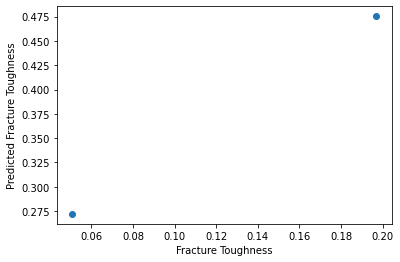

In [323]:
plt.scatter(y_test,pred_test_lasso)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")